In [11]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
import torch
import data_util
from model_interpretation import viz

cn = plt.matplotlib.colors.CenteredNorm()

def cross_entropy(estimator, data, labels):
    logs = estimator.predict_log_proba(data)
    logs_c = -logs[range(len(logs)), labels]

    return logs_c.mean()

root = 'K:/datasets/classification'
n = 5000
random.seed(42)

data_train, labels_train, data_valid, labels_valid = data_util.get_mnist_numpy(root, n)

Accuracy: 89.74
Cross entropy: 0.701461804877288


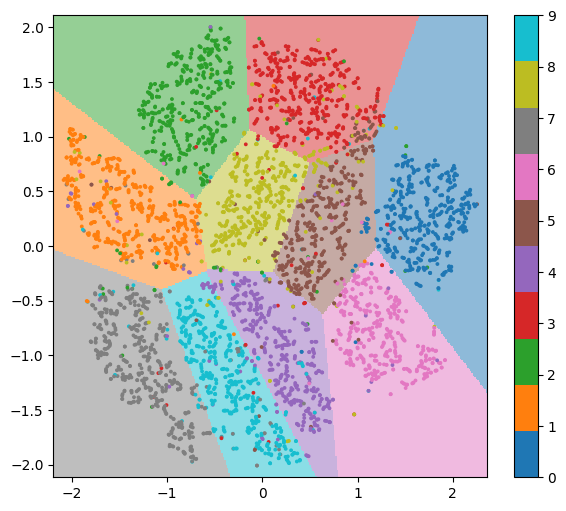

In [12]:
# 2D projection using t-SNE and logistic regression
mapper = TSNE(perplexity=7, learning_rate='auto')
proj_tsne = mapper.fit_transform(data_train)
proj_tsne = data_util.normalize(proj_tsne)
labels_train
logreg = LogisticRegression(C=1000)
logreg.fit(proj_tsne, labels_train)

print('Accuracy:', 100*logreg.score(proj_tsne, labels_train))
print('Cross entropy:', cross_entropy(logreg, proj_tsne, labels_train))

viz.plot_regions(logreg.predict, proj_tsne, labels_train)

## Model interpretation

In [3]:
#logreg = LogisticRegression(C=0.01, max_iter=100, tol=0.1)
logreg = LogisticRegression(C=0.1, penalty="l1", solver="saga", tol=0.1)
logreg.fit(data_train, labels_train)
print('Train accuracy:', logreg.score(data_train, labels_train))
print('Valid accuracy:', logreg.score(data_valid, labels_valid))

Train accuracy: 0.9242
Valid accuracy: 0.901


In [4]:
def create_model(logreg):
    """Create a linear layer using the weights of the logistic regression."""

    model = torch.nn.Linear(28*28, 10)
    model.requires_grad_(False)
    model.weight[:] = torch.tensor(logreg.coef_)
    model.bias[:] = torch.tensor(logreg.intercept_)

    return model

model = create_model(logreg)
data_train_pt = torch.tensor(data_train)
labels_train_pt = torch.tensor(labels_train)

logits = model(data_train_pt)
pred = logits.argmax(dim=1)
acc = (labels_train_pt==pred).sum()/len(labels_train_pt)
print('Accuracy:', 100*acc.item())

Accuracy: 92.41999983787537


### Logistic weights

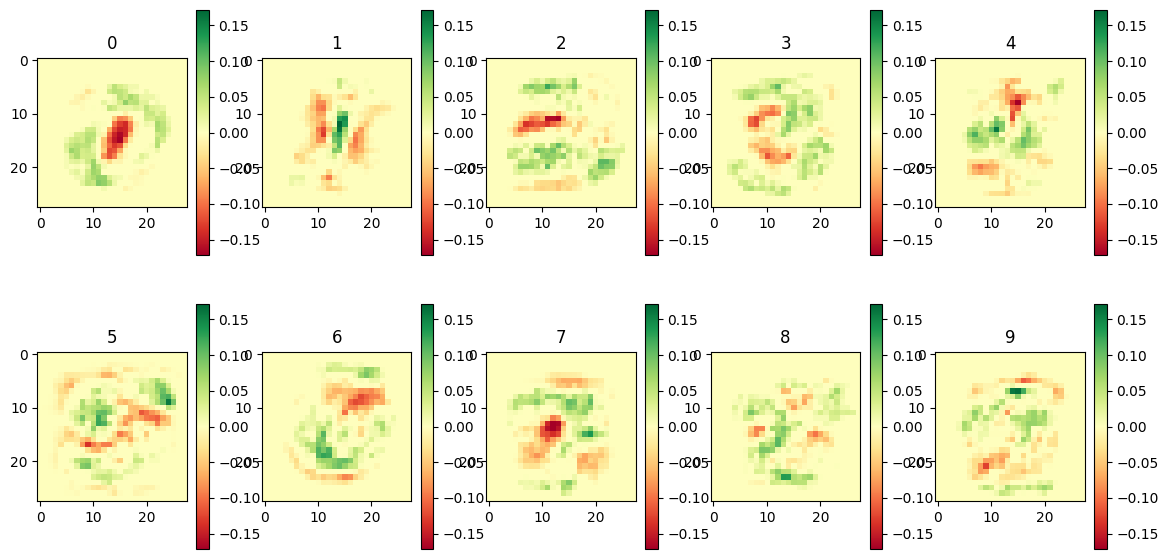

In [5]:
cn = plt.matplotlib.colors.CenteredNorm()
plt.figure(figsize=(14, 7))
for idx in range(10):
    weight = model.weight[idx].reshape(28,28)
    plt.subplot(2, 5, idx+1)
    plt.imshow(weight, 'RdYlGn', norm=cn)
    plt.colorbar()
    plt.title(idx)


### Attributions for an image

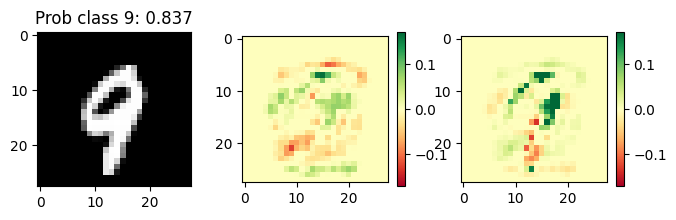

In [6]:
idx = 0
label = labels_train_pt[idx]

x = data_train_pt[idx]
img = x.reshape(28,28)
weight = model.weight[label].reshape(28,28)
prob = model(x[None]).softmax(dim=1)[0][label]

plt.figure(figsize=(8,2))
plt.subplot(1, 3, 1)
plt.imshow(img, 'gray')
plt.title(f'Prob class {label}: {prob:.3f}')
plt.subplot(1, 3, 2)
plt.imshow(weight, 'RdYlGn', norm=cn)
plt.colorbar()
plt.subplot(1, 3, 3)
plt.imshow(weight*img, 'RdYlGn', norm=cn)
plt.colorbar()

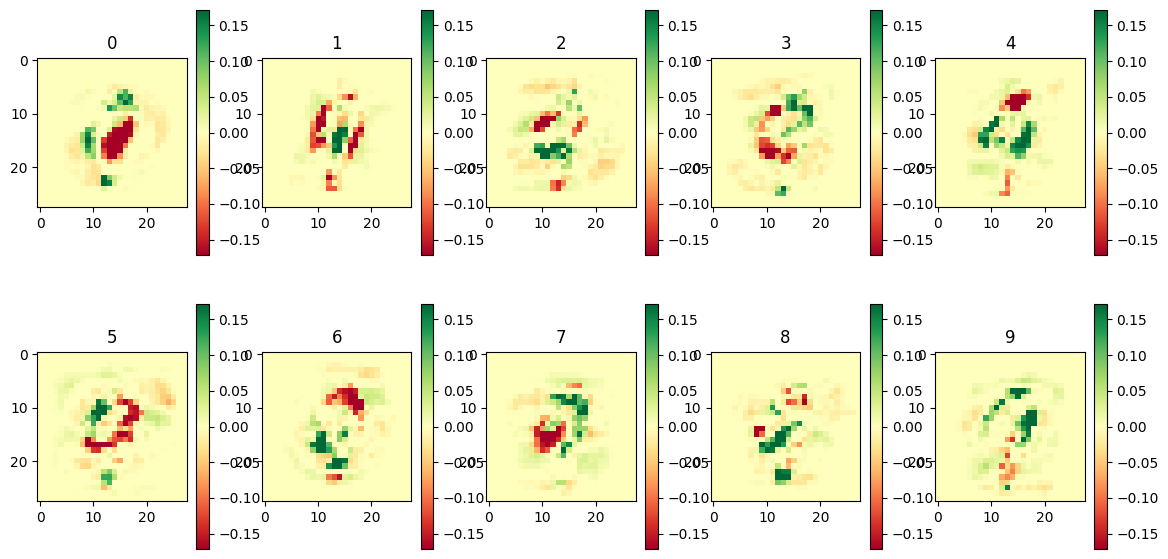

In [7]:
plt.figure(figsize=(14, 7))
for idx in range(10):
    weight = model.weight[idx].reshape(28,28)
    plt.subplot(2, 5, idx+1)
    plt.imshow(weight*img, 'RdYlGn', norm=cn)
    plt.colorbar()
    plt.title(idx)

### 2-class attributions

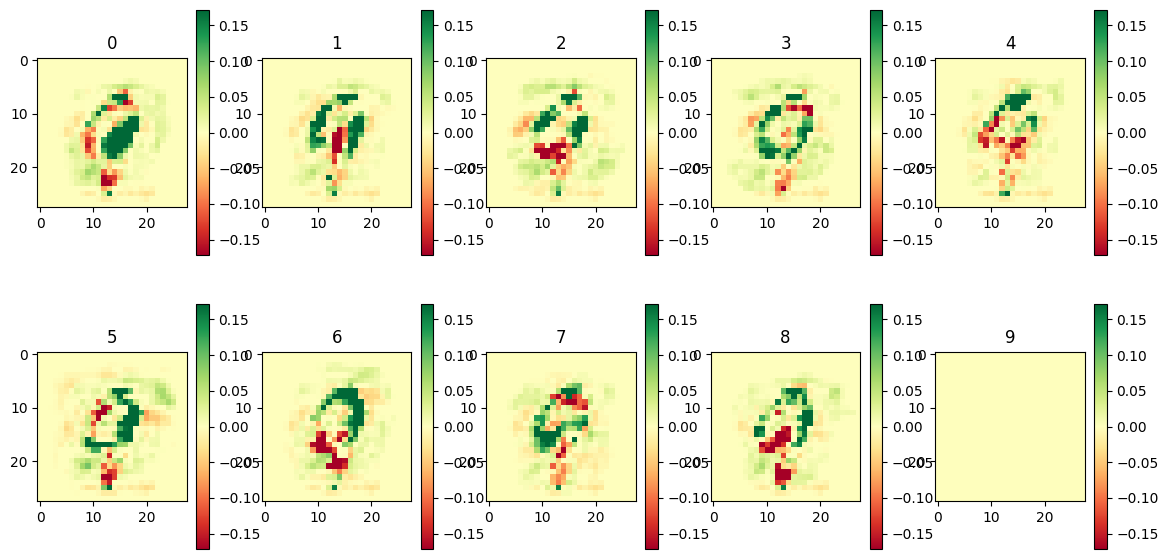

In [8]:
plt.figure(figsize=(14, 7))
for idx in range(10):
    # Get weights that contributed to classify to class label instead of idx
    weight = model.weight[label] - model.weight[idx] 
    weight = weight.reshape(28,28)
    plt.subplot(2, 5, idx+1)
    plt.imshow(weight*img, 'RdYlGn', norm=cn)
    plt.colorbar()
    plt.title(idx)

### 2-class attributions considering class prototypes

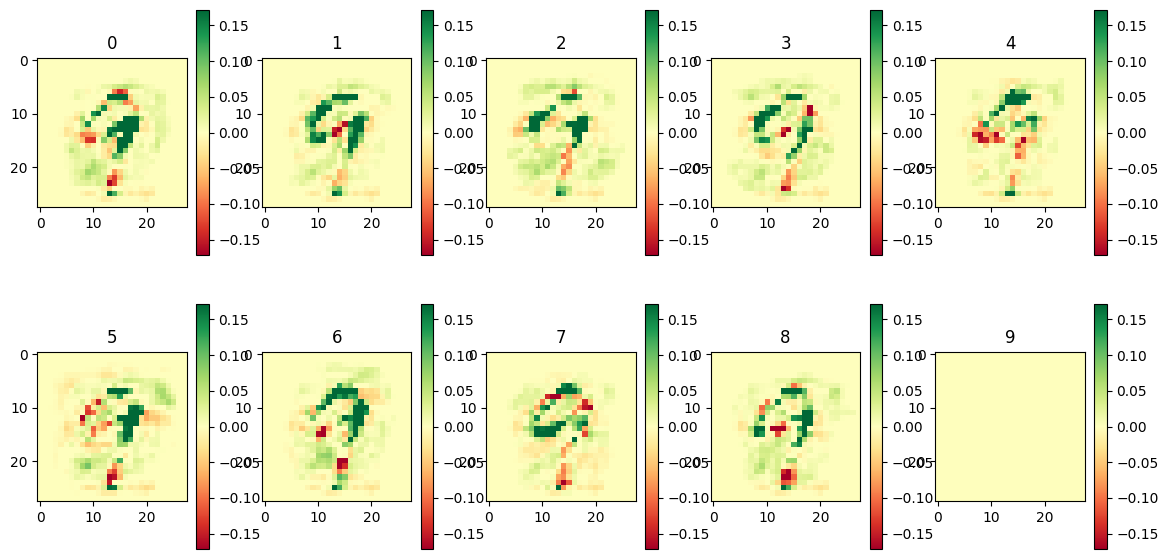

In [9]:
from scipy.spatial import KDTree

# Find samples at the center of each class (warning, average might not be at the peak of the distribution)
tree = KDTree(data_train)
imgs = []
for idx in range(10):
    mean = data_train[np.array(labels_train)==idx].mean(axis=0)
    d, sample_idx = tree.query(mean)
    imgs.append(data_train[sample_idx].reshape(28,28))

plt.figure(figsize=(14, 7))
for idx in range(10):
    weight = model.weight[9] - model.weight[idx]
    weight = weight.reshape(28,28)
    plt.subplot(2, 5, idx+1)
    plt.imshow(weight*imgs[9], 'RdYlGn', norm=cn)
    plt.colorbar()
    plt.title(idx)